Dataset loaded successfully

Duplicate rows before cleaning:
            Date                   Mode           Category  Subcategory Note  \
768    1/12/2017  Saving Bank account 1  Recurring Deposit          NaN  NaN   
868    1/11/2017  Saving Bank account 1  Recurring Deposit          NaN  NaN   
922    1/10/2017  Saving Bank account 1  Recurring Deposit          NaN  NaN   
1007    1/9/2017  Saving Bank account 1  Recurring Deposit          NaN  NaN   
1109    1/8/2017  Saving Bank account 1  Recurring Deposit          NaN  NaN   
1210    1/7/2017  Saving Bank account 1  Recurring Deposit          NaN  NaN   
1362   12/5/2017                   Cash               Food          Tea  NaN   
1816  10/11/2016  Saving Bank account 1         Investment  Mutual fund  NaN   
1854  10/10/2016  Saving Bank account 1         Investment  Mutual fund  NaN   

      Amount Income/Expense Currency  
768   1000.0   Transfer-Out      INR  
868   1000.0   Transfer-Out      INR  
922   1000.0   Transf

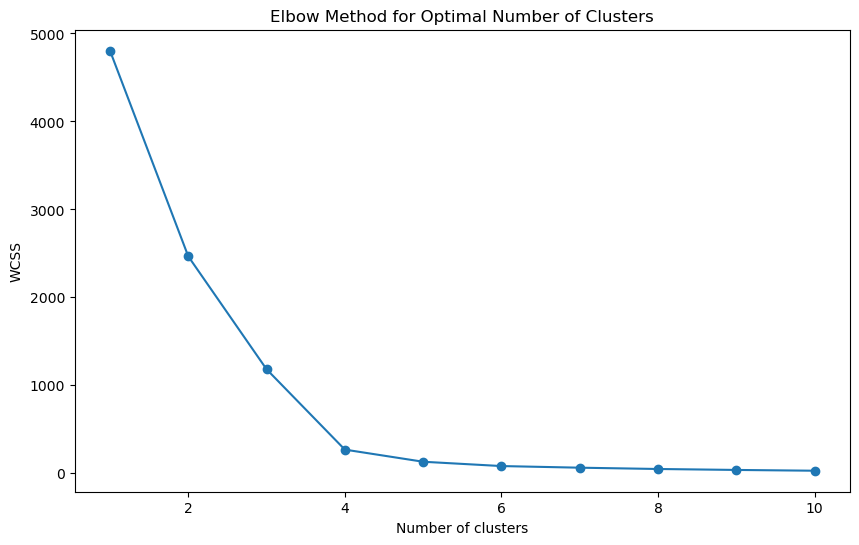


Silhouette Score for 3 clusters: 0.91


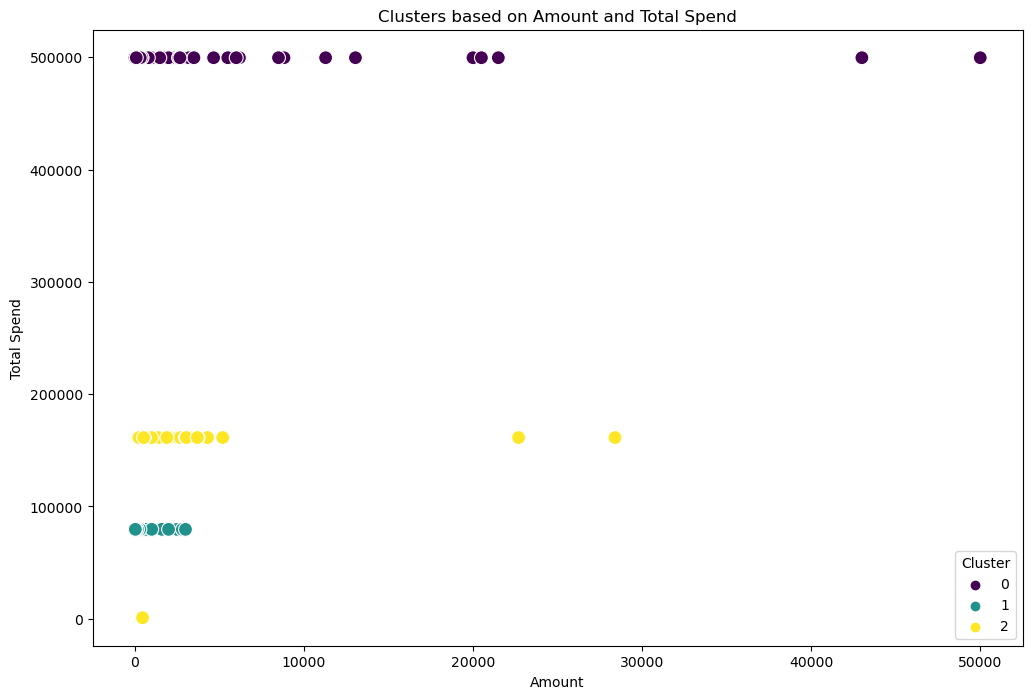

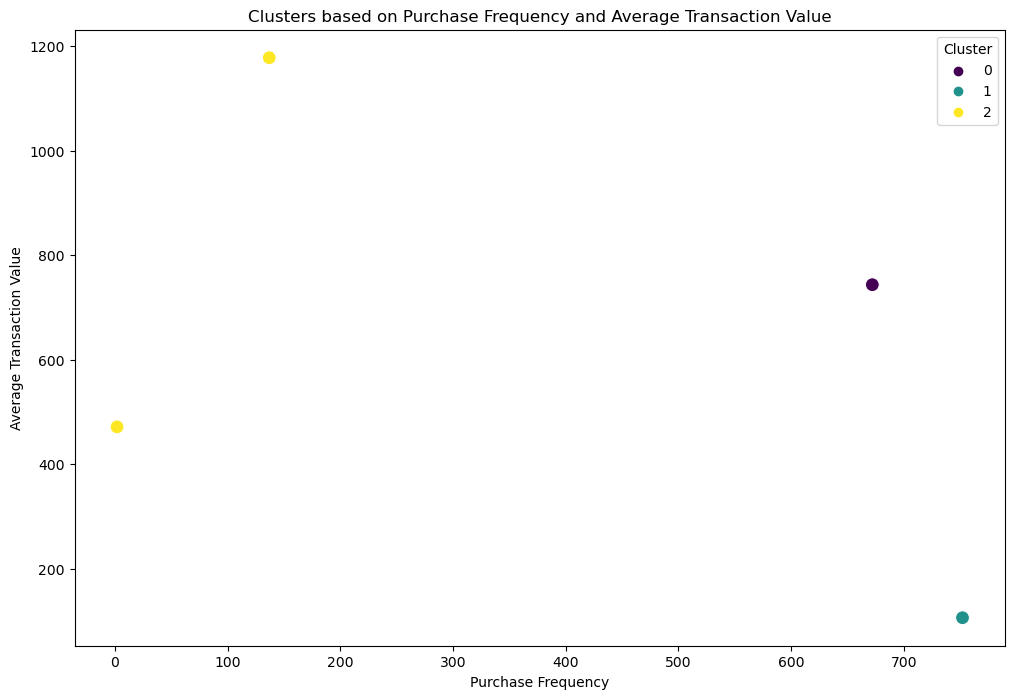

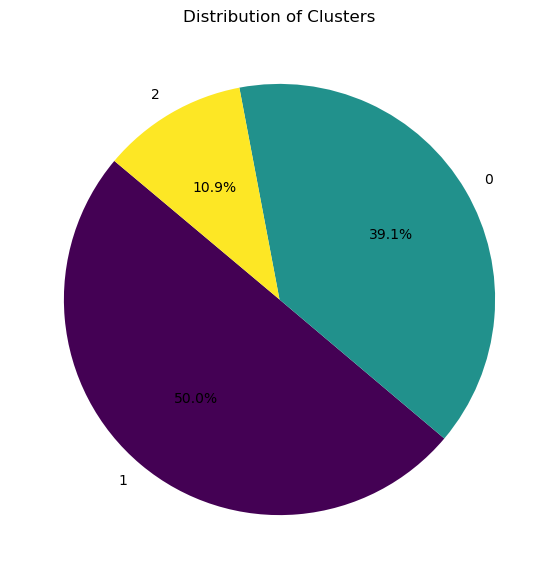

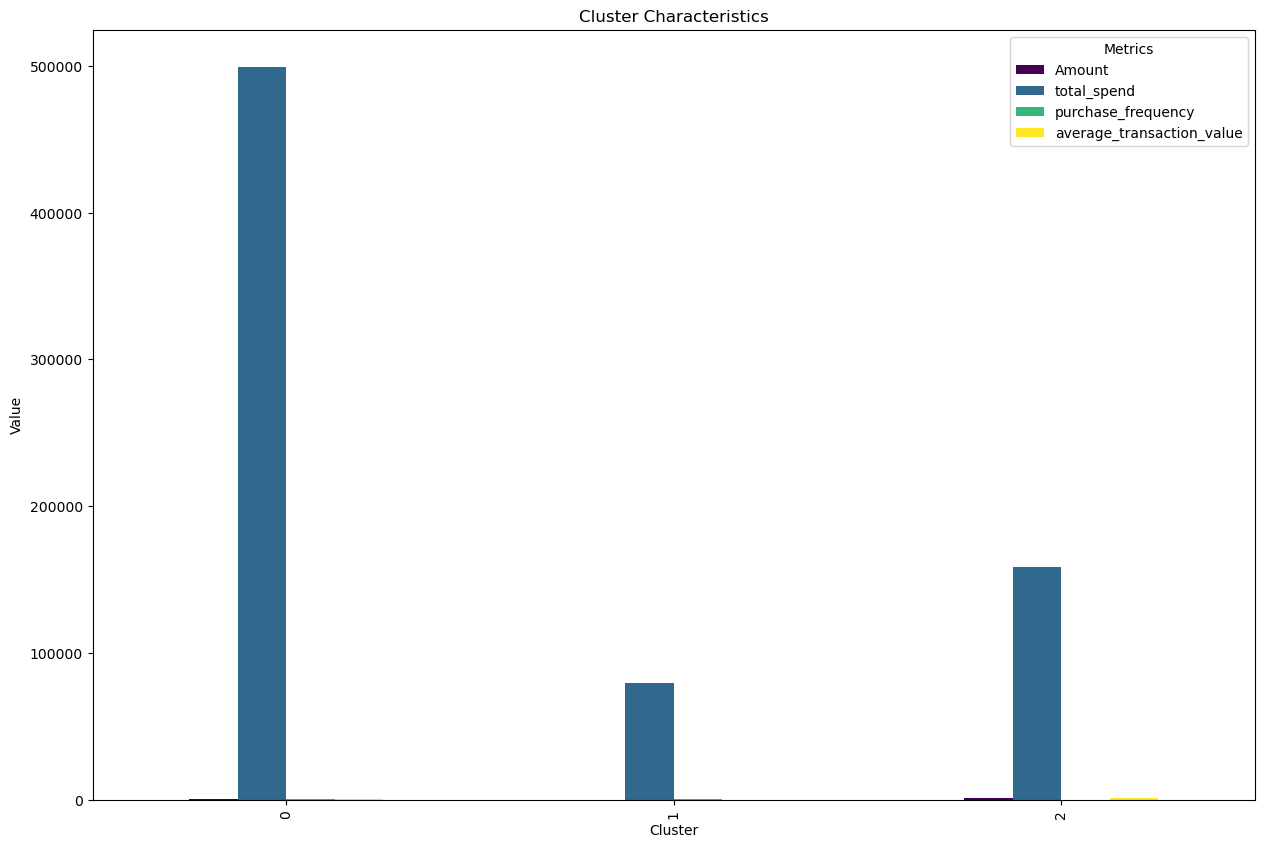

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


warnings.simplefilter(action='ignore', category=FutureWarning)

file_path = r'C:\Users\dell\Desktop\transactions.csv'

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully")

    # Replace infinity values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Find and display duplicate rows before cleaning
    duplicates_before = df[df.duplicated()]
    print("\nDuplicate rows before cleaning:")
    print(duplicates_before)

    # Data cleaning and preprocessing
    df = df.drop_duplicates()
    df = df.dropna()
    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    df['Income/Expense'] = df['Mode'].apply(lambda x: 'Income' if x == 'Income' else 'Expense')
    df['total_spend'] = df.groupby('Mode')['Amount'].transform('sum')
    df['purchase_frequency'] = df.groupby('Mode')['Amount'].transform('count')
    df['average_transaction_value'] = df.groupby('Mode')['Amount'].transform('mean')
    df = df[['Category', 'Subcategory', 'Currency', 'Mode', 'Note', 'Amount', 'Income/Expense', 'total_spend', 'purchase_frequency', 'average_transaction_value']].drop_duplicates()

    # Display dataset after cleaning
    print("\nData after cleaning and preprocessing:")
    print(df.head())

    # Check for missing values after preprocessing
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Selecting features for clustering
    features = df[['Amount', 'total_spend', 'purchase_frequency', 'average_transaction_value']].dropna()

    # Feature scaling
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Finding the optimal number of clusters using the Elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(scaled_features)
        wcss.append(kmeans.inertia_)

    # Plotting the Elbow method graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Applying K-means with the optimal number of clusters (let's assume 3 for this example)
    optimal_clusters = 3
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    df['Cluster'] = kmeans.fit_predict(scaled_features)

    # Evaluating clustering performance
    silhouette_avg = silhouette_score(scaled_features, df['Cluster'])
    print(f"\nSilhouette Score for {optimal_clusters} clusters: {silhouette_avg:.2f}")

    # Visualizing clusters with scatter plots
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Amount', y='total_spend', hue='Cluster', data=df, palette='viridis', s=100)
    plt.title('Clusters based on Amount and Total Spend')
    plt.xlabel('Amount')
    plt.ylabel('Total Spend')
    plt.legend(title='Cluster')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='purchase_frequency', y='average_transaction_value', hue='Cluster', data=df, palette='viridis', s=100)
    plt.title('Clusters based on Purchase Frequency and Average Transaction Value')
    plt.xlabel('Purchase Frequency')
    plt.ylabel('Average Transaction Value')
    plt.legend(title='Cluster')
    plt.show()

    # Adding pie charts for cluster distribution
    plt.figure(figsize=(10, 7))
    df['Cluster'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap='viridis')
    plt.title('Distribution of Clusters')
    plt.ylabel('')
    plt.show()

    # Adding bar graphs for cluster characteristics
    cluster_summary = df.groupby('Cluster').agg({
        'Amount': 'mean',
        'total_spend': 'mean',
        'purchase_frequency': 'mean',
        'average_transaction_value': 'mean'
    }).reset_index()

    cluster_summary.plot(kind='bar', x='Cluster', figsize=(15, 10), colormap='viridis')
    plt.title('Cluster Characteristics')
    plt.xlabel('Cluster')
    plt.ylabel('Value')
    plt.legend(title='Metrics')
    plt.show()

except FileNotFoundError:
    print(f"File not found: {file_path}")
except pd.errors.EmptyDataError:
    print(f"No data found in the file: {file_path}")
except pd.errors.ParserError:
    print(f"Error parsing the file: {file_path}")
